#  K-Means Clustering Overview

K-Means clustering is a method used to group data points based on their similarity. It works by initially selecting a set of central points, known as **centroids**. Each data point is assigned to the nearest centroid, forming clusters. After all points are assigned, the centroids are updated by calculating the average position of the points in each cluster. This process of assigning and updating continues until the centroids stabilize and no longer change significantly.

The objective of K-Means clustering is to partition the data in such a way that points within the same cluster are more similar to each other than to those in other clusters.



##  Why We Chose K-Means
We chose K-Means because it is simple, fast, and works well with numeric data. It allows us to easily group similar products into clusters, which helps improve recommendations by narrowing down product options based on patterns in the data.

In [62]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your dataset (if not already loaded)
df = pd.read_csv("Dataset/processed_file.csv")

# Drop irrelevant or non-numeric columns
columns_to_drop = [
    'Unnamed: 0', 'product_href', 'product_name', 'product_type', 'brand',
    'notable_effects', 'skintype', 'description', 'picture_src', 'labels'
]
df_clean = df.drop(columns=columns_to_drop)

# Drop rows with missing values (only price_SAR had some)
df_clean = df_clean.dropna()

# Scale the features (important for clustering)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean)

# Optionally, convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df_clean.columns)

# Preview the cleaned and scaled data
scaled_df.head()

# Save to a new CSV file
scaled_df.to_csv("Dataset/processed_for_clustering.csv", index=False)


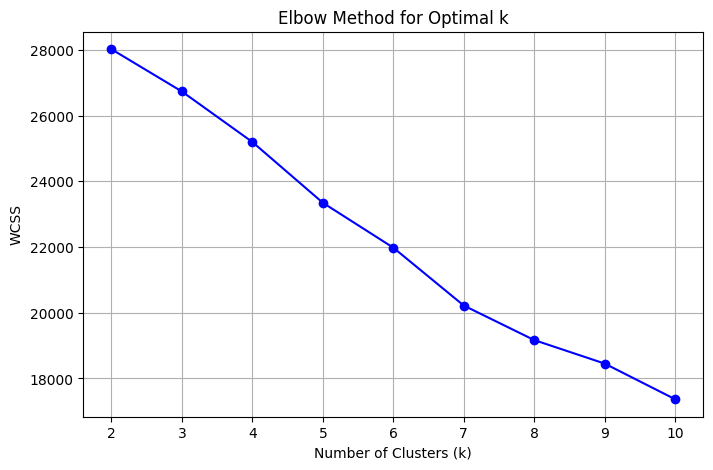

In [63]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df.drop('Cluster', axis=1, errors='ignore'))
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


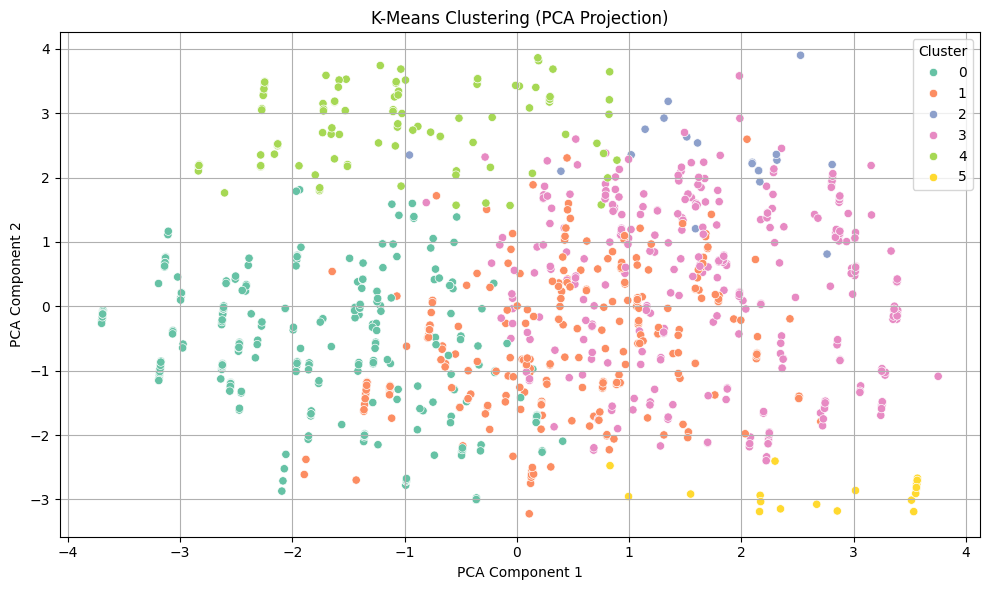

Silhouette Score: 0.1487
WCSS (Total Within-Cluster Sum of Squares): 21979.82


In [64]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Apply KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(scaled_df)

# Step 2: Add cluster labels to the dataframe
scaled_df['Cluster'] = clusters

# Step 3: Visualize with PCA (2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df.drop('Cluster', axis=1))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=clusters, palette='Set2')
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Evaluate using Silhouette Score
silhouette = silhouette_score(scaled_df.drop('Cluster', axis=1), clusters)
print(f"Silhouette Score: {silhouette:.4f}")


import pandas as pd
pd.set_option('display.max_columns', None)  # Optional: show all columns


# Total Within-Cluster Sum of Squares
wcss = kmeans.inertia_
print(f"WCSS (Total Within-Cluster Sum of Squares): {wcss:.2f}")


In [65]:
# Add cluster labels to original scaled data
scaled_df['Cluster'] = clusters

# Save to CSV
scaled_df.to_csv("Dataset/clustered_data_k6.csv", index=False)


Using the Elbow Method and Silhouette Score, we determined that k=6 provides a reasonable balance between cluster compactness and interpretability for our dataset.

## How Clusters Are Used to Improve Recommendations
Clustering helps us discover hidden patterns in the dataset by grouping similar products together based on their features. After applying K-Means, each product is assigned to a specific cluster. These clusters can then be used to enhance recommendations in the following way:


- Instead of recommending from the entire dataset, we filter products from the most relevant cluster, ensuring more targeted and meaningful suggestions.

- This improves the efficiency and relevance of recommendations by focusing on products that share similar characteristics.

By leveraging clustering, we introduce an additional layer of personalization that is independent of explicit labels, allowing the system to generalize better and uncover relationships that may not be obvious

✅ Improved Accuracy with Cluster (One-Hot): 0.60
📊 Precision: 0.60
📊 Recall: 0.60
📊 F1-score: 0.59

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.47      0.56        40
           1       0.45      0.41      0.43        41
           2       0.61      0.78      0.69        79
           3       0.84      0.76      0.80        42
           4       0.41      0.38      0.39        40

    accuracy                           0.60       242
   macro avg       0.60      0.56      0.57       242
weighted avg       0.60      0.60      0.59       242



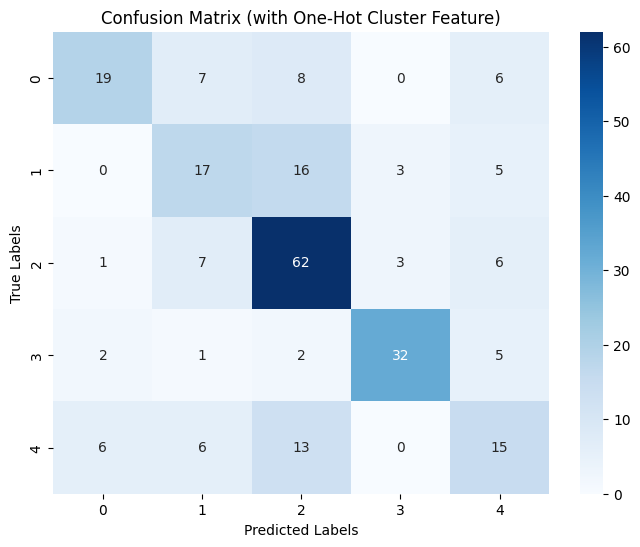

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from catboost import CatBoostClassifier

# =======================
# LOAD DATA
# =======================

# Original dataset
df = pd.read_csv("Dataset/processed_file.csv")

# Cluster labels (from KMeans clustering step)
clusters = pd.read_csv("Dataset/clustered_data_k6.csv")
df['Cluster'] = clusters['Cluster']

# =======================
# FEATURE ENGINEERING
# =======================

# One-hot encode 'brand'
X = pd.get_dummies(df[['brand']], columns=['brand'])

# Add skin type and notable effects (already binary-encoded)
notable_effects_columns = [col for col in df.columns if col.startswith('notable_effects_')]
skin_type_columns = ['Sensitive', 'Combination', 'Oily', 'Dry', 'Normal']
X[notable_effects_columns + skin_type_columns] = df[notable_effects_columns + skin_type_columns]

# One-hot encode the 'Cluster' column instead of treating it as numeric
X = pd.concat([X, pd.get_dummies(df['Cluster'], prefix='Cluster')], axis=1)

# Scale numerical features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode target variable (product_type)
y = LabelEncoder().fit_transform(df['product_type'].astype(str))

# =======================
# TRAIN/TEST SPLIT
# =======================

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# =======================
# CATBOOST TRAINING
# =======================

catboost_classifier = CatBoostClassifier(
    iterations=2000,
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=3,
    loss_function='MultiClass',
    random_seed=42,
    eval_metric="Accuracy",
    verbose=0
)

catboost_classifier.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, use_best_model=True)

# =======================
# EVALUATION
# =======================

y_pred = catboost_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f'✅ Improved Accuracy with Cluster (One-Hot): {accuracy:.2f}')
print(f'📊 Precision: {precision:.2f}')
print(f'📊 Recall: {recall:.2f}')
print(f'📊 F1-score: {f1:.2f}\n')

print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

# =======================
# CONFUSION MATRIX
# =======================

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (with One-Hot Cluster Feature)')
plt.show()


## References  
[1] A. Aggarwal, "K-Means Clustering - Introduction," GeeksforGeeks, Aug. 3, 2023. [Online]. Available: https://www.geeksforgeeks.org/k-means-clustering-introduction/